This is an implementation of the paper "U-Net: Confolutional Networks for Biomedical Image Segmentation" https://arxiv.org/pdf/1505.04597.pdf

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import gzip
import tarfile
import gc
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
 
#A Class for downloading the dataset
class CancerDataset(Dataset):
    def __init__(self, root, download=True, size=512, train=True):
        if download and not os.path.exists(os.path.join(root, 'cancer_data')):
            torchvision.datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
            print(os.path.join(root, 'cancer_data.tar.gz'))
            self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
            self.extract_tar('/tmp/cancer/cancer_data.tar')
 
        postfix = 'train' if train else 'test'
        root = os.path.join(root, 'cancer_data', 'cancer_data')
        self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size),torchvision.transforms.ToTensor()]))
        self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size),torchvision.transforms.ToTensor()]))
 
    def extract_gzip(self, gzip_path, remove_finished=False):
        print('Extracting {}'.format(gzip_path))
        print(gzip_path)
        with open('/tmp/cancer/cancer_data.tar', 'wb') as out_f, gzip.GzipFile('/tmp/cancer/cancer_data.tar.gz') as zip_f:
            out_f.write(zip_f.read())
        if remove_finished:
            os.unlink('/tmp/cancer/cancer_data.tar')
 
    def extract_tar(self, tar_path):
        print('Untarring {}'.format(tar_path))
        z = tarfile.TarFile(tar_path)
        z.extractall(tar_path.replace('.tar', ''))
 
 
    def __getitem__(self,index):
        img = self.dataset_folder[index]
        label = self.label_folder[index]
        return img[0],label[0][0]
 
    def __len__(self):
        return len(self.dataset_folder)




In [19]:
#Cancer Detection class using the u-net structure
class CancerDetection(nn.Module):
    def __init__(self, dataset):
        super(CancerDetection, self).__init__()
        #The convolution parameters as given by the paper
        a = 3
        b = 64
        c = 128
        d = 256
        e = 512
        f = 1024
        
        #The convolutions
        self.conv1 = conv(a,b)
        self.conv2 = conv(b,c)
        self.conv3 = conv(c,d)
        self.conv4 = conv(d,e)
        self.conv5 = conv(e,f)
        self.conv6 = conv(f,e)
        self.conv7 = conv(e,d)
        self.conv8 = conv(d,c)
        self.conv9 = conv(c,b)
        self.conv10 = nn.Conv2d(64,2,1,1,0)
        
        #The convolution transposes
        self.trans1 = nn.ConvTranspose2d(1024,512,kernel_size = 2, stride = 2, padding = 0)
        self.trans2 = nn.ConvTranspose2d(512,256,kernel_size = 2, stride = 2, padding = 0)
        self.trans3 = nn.ConvTranspose2d(256,128,kernel_size = 2, stride = 2, padding = 0)
        self.trans4 = nn.ConvTranspose2d(128,64,kernel_size = 2, stride = 2, padding = 0)
        self.pool = nn.MaxPool2d(kernel_size = 2)
    
    #The forward function for feeding through the network
    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.pool(conv1_out))
        conv3_out = self.conv3(self.pool(conv2_out))
        conv4_out = self.conv4(self.pool(conv3_out)) 
        conv5_out = self.conv5(self.pool(conv4_out))
        conv6_out = self.conv6(torch.cat((self.trans1(conv5_out), conv4_out),1))
        conv7_out = self.conv7(torch.cat((self.trans2(conv4_out), conv3_out),1))
        conv8_out = self.conv8(torch.cat((self.trans3(conv3_out), conv2_out),1))
        conv9_out = self.conv9(torch.cat((self.trans4(conv2_out), conv1_out),1))
        conv10_out = self.conv10(conv9_out)
        return conv10_out

#A smaller convolution class that includes a convolution, relu, and batch norms to simplify the code.
class conv(nn.Module):
    def __init__(self,a,b):
        super(conv, self).__init__()
        self.conv1 = nn.Conv2d(a,b,kernel_size = 3, stride = 1, padding = 1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(b,b,kernel_size = 3, stride = 1, padding = 1)
        self.batch1 = nn.BatchNorm2d(b)
        self.batch2 = nn.BatchNorm2d(b)
        self.relu4 = nn.ReLU()
       
        
    def forward(self, x):
        conv1_out = self.conv1(x)
        batch1_out = self.batch1(conv1_out)
        relu2_out = self.relu2(batch1_out)
        conv3_out = self.conv3(relu2_out)
        batch2_out = self.batch2(conv3_out)
        relu4_out = self.relu4(batch2_out) 
        return relu4_out

def scope():
    try:
        #Get the cancer dataset
        train_dataset = CancerDataset('/tmp/cancer', download=True,train=True)
        val_dataset = CancerDataset('/tmp/cancer', download=True,train=False)
        
        #Get a test image
        final_test_img = val_dataset[172][0].cuda()
        final_test_label = val_dataset[172][1].cuda()
        
        #instantiate the model, optimizer and loss
        model = CancerDetection(train_dataset)
        model = model.cuda()
        my_objective = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        
        #Get the data
        train_loader = DataLoader(train_dataset, batch_size=2, pin_memory=True, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2, pin_memory=True,shuffle=True)
        

        #Used to keep my GPU clean
        gc.collect()

        #Various variables for keeping track of losses and accuracy
        my_losses = []
        val_losses = []
        accuracy = []
        global accuracy_avg_loss
        accuracy_avg_loss = []
        global val_avg_loss 
        val_avg_loss = []
        global my_avg_loss 
        my_avg_loss = []
        loop = tqdm(total=len(train_loader)*6, position=0)
        counter = 0
        
        #Start the iterations and do 6 epochs
        for epoch in range(6):
            
            #Load the data
            for x, y_truth in train_loader:
                x, y_truth = x.cuda(async=True), y_truth.cuda(async=True) 
                
                #Get the gradient and losses
                optimizer.zero_grad()
                y_hat = model(x)
                my_loss = my_objective(y_hat, y_truth.long())
                my_losses.append(my_loss.item())
                
                #Append the accuracy and update the updater
                accuracy.append((y_hat.argmax(1) == y_truth.long()).float().mean())
                loop.set_description('loss:{:.4f}'.format(my_loss.item()))
                loop.update(1)

                #Update the model
                my_loss.backward()
                optimizer.step()
                
                #Run on the validation set every 100 batches
                if (counter % 100 == 0):
                    for x, y_truth in val_loader:
                        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
                        y_hat = model(x)
                        loss = my_objective(y_hat, y_truth.long())
                        val_losses.append(loss.item())
                counter+=1  
                
            #Get the average losses and accuracies
            val_avg_loss.append(np.mean(val_losses))
            val_losses.clear()
            my_avg_loss.append(np.mean(my_losses))
            my_losses.clear()
            accuracy_avg_loss.append(np.mean(accuracy))
            accuracy.clear()
        
        #Return a final image, label, and the model
        return(final_test_img, final_test_label, model(final_test_img.unsqueeze(0)))


        loop.close() 


    except:
        __ITB__()
final_test_img, final_test_label, mypic = scope()

loss:0.0542: 100%|██████████| 4026/4026 [39:56<00:00,  2.97it/s]  

## Loss Vs. Time Graph

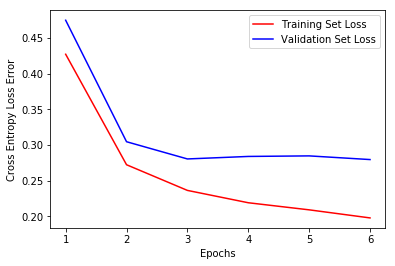

In [22]:
#Plot the loss over the epochs
plt.plot(range(1,7),my_avg_loss, color = 'r', label = "Training Set Loss")
plt.plot(range(1,7),val_avg_loss, color = 'b', label = "Validation Set Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss Error")
plt.legend()
plt.show()

# Test Image Prediction

In [23]:
#Time to test on an image
final_test_img = final_test_img.view(3,512,512)
final_test_label = final_test_label.view(512,512)
mypic= mypic.view(2,512,512)

## Original Image

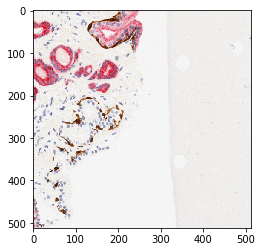

In [24]:
plt.imshow(final_test_img.permute(1,2,0))
plt.show()

## Original Image Cancer Truth

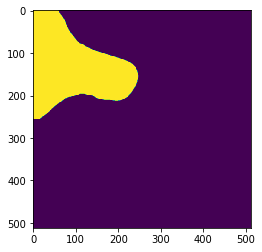

In [25]:
plt.imshow(final_test_label)
plt.show()

## Image Prediction and Accuracy

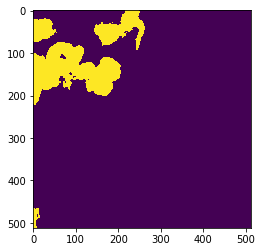

In [26]:
values, indexes = mypic.max(dim=0)
plt.imshow(indexes)

plt.show()

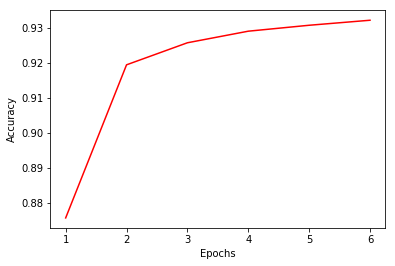

In [27]:
#Plot the accuracy over time
plt.plot(range(1,7),accuracy_avg_loss, color = 'r')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()